# Udacity: Intro to Machine Learning - Final Project

In [1]:
import math
%matplotlib inline 
import matplotlib.pyplot as plt

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Introduction 

In this project we'll use Machine Learning to identify persons of interest (POIs) in the Enron case of the early 2000s.

Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives.

The sheer size of the data set makes it very cumbersome for humans to analyze, however given that the data is available in a digital format it lends itself well to be analyzed using Machine Learning techniques. This report documents the machine learning techniques used in building a POI identifier.

There are four major steps in my project:

1. Data & Questions
2. Feature Selection
3. Algorithm Selection
4. Tuning & Validation

### 1 Data Exploration

#### 1.1 Initial investigation

In [2]:
## total number of data points
print "total number of data points:", len(data_dict)


## allocation across classes (POI/non-POI)
print "Allocation across classes:"
poi_count = 0
non_poi_count = 0
for name in data_dict:
    if data_dict[name]['poi'] == True:
        poi_count += 1
    else:
        non_poi_count += 1
print "    POI:", poi_count
print "    Not POI:", non_poi_count


## number of features
sample_features = data_dict[data_dict.keys()[0]]
print "Data is available for the following", len(sample_features), "features:"
for feature in sample_features:
        print "    -", feature


## are there features with many missing values?
print "Missing values for each feature:"
nan_dict = {}
for feature in sample_features:
    count = 0
    for name in data_dict:
        try:
            if math.isnan(float(data_dict[name][feature])):
                count += 1
        except:
            pass
    nan_dict[feature] = count
print nan_dict

total number of data points: 146
Allocation across classes:
    POI: 18
    Not POI: 128
Data is available for the following 21 features:
    - salary
    - to_messages
    - deferral_payments
    - total_payments
    - exercised_stock_options
    - bonus
    - restricted_stock
    - shared_receipt_with_poi
    - restricted_stock_deferred
    - total_stock_value
    - expenses
    - loan_advances
    - from_messages
    - other
    - from_this_person_to_poi
    - poi
    - director_fees
    - deferred_income
    - long_term_incentive
    - email_address
    - from_poi_to_this_person
Missing values for each feature:
{'salary': 51, 'to_messages': 60, 'deferral_payments': 107, 'total_payments': 21, 'loan_advances': 142, 'bonus': 64, 'email_address': 35, 'restricted_stock_deferred': 128, 'total_stock_value': 20, 'shared_receipt_with_poi': 60, 'long_term_incentive': 80, 'exercised_stock_options': 44, 'from_messages': 60, 'other': 53, 'from_poi_to_this_person': 60, 'from_this_person_to_poi':

#### 1.2 Outlier Removal

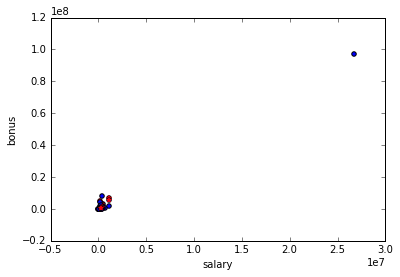

In [3]:
features = ["poi", "salary", "bonus"]
data = featureFormat(data_dict, features)


### write function for plot
def dot_plot(data, features):
    for point in data:
        x_axis = point[1]
        y_axis = point[2]
        plt.scatter( x_axis, y_axis )
        if point[0] == 1:
            plt.scatter(x_axis, y_axis, color="r", marker="*")
    
    plt.xlabel(features[1])
    plt.ylabel(features[2])
    plt.show()
dot_plot(data, features)

In [4]:
## Identify outlier(s)
def outliers(feature, n):
    outliers = []
    data = featureFormat(data_dict, features)
    for key in data_dict:
        val = data_dict[key][feature]
        if val == 'NaN':
            continue
        outliers.append((key,int(val)))
    
    max_outliers = sorted(outliers,key=lambda x:x[1],reverse=True)[:n]
    return max_outliers
    
print outliers('salary', 1)

[('TOTAL', 26704229)]


The 'TOTAL' entry seems to sum up all the individual data points:

In [5]:
total = 0
for name in data_dict:
    try:
        total += data_dict[name]['salary']
    except:
        pass
print total

53408458


Since we're only interested in the actual observations, the best course of action is to remove it.

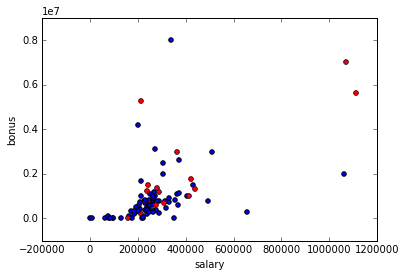

In [6]:
## Remove and plot again
data_dict.pop('TOTAL')
data = featureFormat(data_dict, features)

dot_plot(data, features)

There's a cluster of points and then a number of points seem to fan out from that cluster. Let's investigate those in more detail:

In [7]:
print outliers('salary', 3)
print outliers('bonus', 3)

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932)]
[('LAVORATO JOHN J', 8000000), ('LAY KENNETH L', 7000000), ('SKILLING JEFFREY K', 5600000)]


These datapoints pertain to people high up in the organisation and charged with fraud, so it sounds plausible that they had significantly higher salaries / bonuses. We will leave the data unchanged.

### 2 Feature Selection

#### 2.1 Feature Creation

Fraud at the scale of Enron requires collusion amongst a network of people. It's reasonable to assume that the structure of a network is reflected in the amount of emails members of the network send each other. Let's investigate the features 'from_poi_to_this_person' and 'from_this_person_to_poi'.

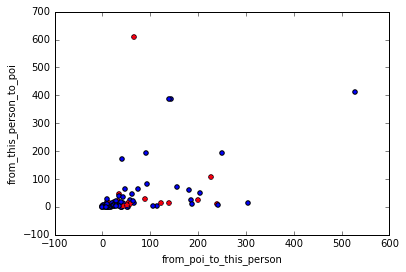

In [8]:
features = ['poi', 'from_poi_to_this_person', 'from_this_person_to_poi']
data = featureFormat(data_dict, features)

dot_plot(data, features)

In [9]:
print outliers('from_poi_to_this_person', 4)
print outliers('from_this_person_to_poi', 4)

[('LAVORATO JOHN J', 528), ('DIETRICH JANET R', 305), ('KITCHEN LOUISE', 251), ('FREVERT MARK A', 242)]
[('DELAINEY DAVID W', 609), ('LAVORATO JOHN J', 411), ('KEAN STEVEN J', 387), ('BECK SALLY W', 386)]


We would have expected a high correlation between incoming and outgoing email to/from POIs, however this correlation seems weak. I.e., David Delainey seems to have a lot of email from POIs, but relatively little sent. Similarly, several people sent 200+ emails to POIs, but received very few back. As a result, the POI observations in red look mixed in with the non-POI observations. 

Perhaps this is due to the fact that some people generally send a lot more email than others. So let's create a new feature that gives us the ratio of incoming/outgoing emails to/from POIs.

In [10]:
# create new dataset 'my_dataset' as per poi_id.py file instructions
my_dataset = data_dict
for name in data_dict:
    try:
        my_dataset[name]['from_poi_ratio'] = float(data_dict[name]['from_poi_to_this_person']) / data_dict[name]['to_messages']
    except:
        my_dataset[name]['from_poi_ratio'] = 0
    try:
        my_dataset[name]['to_poi_ratio'] = float(data_dict[name]['from_this_person_to_poi']) / data_dict[name]['from_messages']
    except:
        my_dataset[name]['to_poi_ratio'] = 0

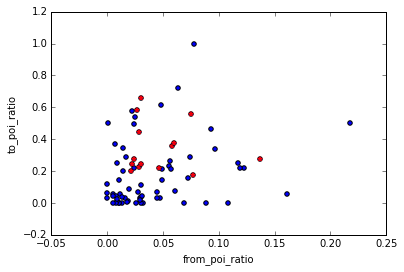

In [11]:
#print data_dict[data_dict.keys()[0]]
features = ["poi", "from_poi_ratio", "to_poi_ratio"]
data = featureFormat(my_dataset, features)

dot_plot(data, features)

This looks better; the correlation between the variables seems clearer and the POIs are closer together and easier to identify.

#### 2.2 Feature Reduction

Given the skewed nature of the dataset (18 positives, 128 negatives) we will select a feature reduction method based on reducing false positives, SelectFpr. We will start using all available features and then subtract step by step.

In [12]:
features_list = ["poi", "salary", "bonus", "to_poi_ratio", "from_poi_ratio",
            "deferral_payments", "total_payments", "loan_advances", "restricted_stock_deferred",
            "deferred_income", "total_stock_value", "expenses", "exercised_stock_options",
            "long_term_incentive", "shared_receipt_with_poi", "restricted_stock", "director_fees"]
data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)


### split data into training and testing datasets
#from sklearn import cross_validation
#features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)


from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import chi2, f_classif
univariate_filter = SelectFpr(f_classif, alpha = 0.0001)
filtered_features = univariate_filter.fit(features, labels).transform(features)
feature_tf = univariate_filter.get_support(indices=False)
feature_indices = univariate_filter.get_support(indices=True)

#print feature_tf
#print feature_indices
print "The SelectFpr algorhithm suggests using only the following features:"

# Start new features_list, seeding 'poi' as the dependent
reduced_features_list = ['poi']
for i in feature_indices:
    reduced_features_list.append(features_list[i+1])
print reduced_features_list
    

The SelectFpr algorhithm suggests using only the following features:
['poi', 'salary', 'bonus', 'to_poi_ratio', 'total_stock_value', 'exercised_stock_options']


### 3 Algorhithm Selection

It's important to evaluate algorhitms against a test set that they haven't been trained against. This prevents overfitting to available data. For that purpose we will first split the data into test & training sets and define a function to evaluate the predictions of the algorhithms we'll investigate.

In [13]:
# Rebuild labels & features with reduced_features_list
data = featureFormat(my_dataset, reduced_features_list)
labels, features = targetFeatureSplit(data)

# Build train and test sets for cross validation
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, 
                                                                                             test_size=0.3, 
                                                                                             random_state=42)

In [77]:
# Functions for evaluating outcomes
def eval(pred, print_or_return = "print"):
    #convert true values to True/False and print
    true_list = []
    for i in labels_test:
        true_list.append(bool(i))
    
    #convert prediction values to True/False and print
    pred_list = []
    for i in pred:
        pred_list.append(bool(i))
    
    #calculate confusion matrix, precision & recall
    from sklearn.metrics import confusion_matrix, precision_score, recall_score
    precision = precision_score(true_list, pred_list)
    recall = recall_score(true_list, pred_list)
    
    #print or return
    if print_or_return == "print":
        print "True values     :", true_list
        print "Predicted values:", pred_list
        print "Confusion Matrix:"
        print confusion_matrix(true_list, pred_list)
        print "Precision:", precision
        print "Recall:", recall
    else:
        return precision, recall

#### 3.1 Naive Bayes 

In [73]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf = clf.fit(features_train, labels_train)   

pred = clf.predict(features_test)
accuracy = clf.score(features_test, labels_test)
print "Accuracy:", accuracy

eval(pred)

Accuracy: 0.775
True values     : [False, False, False, False, False, False, True, False, True, False, False, True, False, True, False, False, False, True, False, False, False, False, True, False, True, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False]
Predicted values: [False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False]
Confusion Matrix:
[[29  1]
 [ 8  2]]
Precision: 0.666666666667
Recall: 0.2


#### 3.2 SVM 

In [74]:
from sklearn.svm import SVC
clf = SVC()
clf = clf.fit(features_train, labels_train)   

pred = clf.predict(features_test)
accuracy = clf.score(features_test, labels_test)
print "Accuracy:", accuracy

eval(pred)

Accuracy: 0.75
True values     : [False, False, False, False, False, False, True, False, True, False, False, True, False, True, False, False, False, True, False, False, False, False, True, False, True, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False]
Predicted values: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
Confusion Matrix:
[[30  0]
 [10  0]]
Precision: 0.0
Recall: 0.0


#### 3.3 Decision Tree

In [63]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)

pred = clf.predict(features_test)
accuracy = clf.score(features_test, labels_test)
print "Accuracy:", accuracy

eval(pred)

Accuracy: 0.75
True values     : [False, False, False, False, False, False, True, False, True, False, False, True, False, True, False, False, False, True, False, False, False, False, True, False, True, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False]
Predicted values: [False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False]
Confusion Matrix:
[[28  2]
 [ 8  2]]
Precision: 0.5
Recall: 0.2


#### 3.4 Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(features_train, labels_train)

pred = clf.predict(features_test)
accuracy = clf.score(features_test, labels_test)
print "Accuracy:", accuracy

eval(pred)

Accuracy: 0.8
True values     : [False, False, False, False, False, False, True, False, True, False, False, True, False, True, False, False, False, True, False, False, False, False, True, False, True, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False]
Predicted values: [False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False]
Confusion Matrix:
[[29  1]
 [ 7  3]]
Precision: 0.75
Recall: 0.3


The SVM algorhithm took the "shortcut" to simply declare nobody a POI, which gives it a relatively high accuracy at 0.75, but of course 0 precision and recall. I was somewhat surprised by the fact that Naive Bayes outperformed the decision tree algorhithm, given that decision trees are generally able to handle intercorrelation better and we saw earlier that some variables have correlation. Overall however, the Random Forest (which is an ensemble of decision trees) showed the best performance across all 3 metrics, accuracy, precision and recall.

### 4 Tuning and Validation 

At a first glance, the accuracy we found with the algorhithms above looks quite high, ranging between 0.75 and 0.8. However, given the class-imbalance, namely that 75% of observations are not POIs, this number becomes less impressive. More specifically, due tot he imbalance it's easy to identify (or guess correctly) the non-POIs, whereas what we really set out to do is identifying POIs.

That's why we should focus more on the precision and recall scores. Doing that we see that even the best algorhithm above, the Random Forest, is not performing really well yet at identifying the POIs. Our precision is quite ok at 3 out of 4 predicted POIs actually being POIs (Precision of 0.75). However, the prediction is still "too conservative" in the sense that out of 10 POIs, only 3 were identified (0.3 Recall).

So we will tune the Random Forest and evaluate not only accuracy but more so precision and especially recall.

Specifically, we will look at 3 parameters: (1) class_weight, (2) min_samples_split, and (3) n_estimators.

#### 4.1 class_weight

Given the class-imbalance, it looks like the parameter class_weight could help address it. Besides the default "None", we can pick between "balanced" and "balanced_subsample". In an initial run the performance actually decreased when using the latter, however this is really counter-intuitive. We will therefore set the default to "balanced" while tweaking the other parameters, then revisit class_weight once the other two parameters are tweaked.

In [99]:
# Define base Random Forest Classifier
def randomForestclf(class_weight = "balanced", min_samples_split = 2, n_estimators = 10):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(class_weight = class_weight, 
                                 min_samples_split = min_samples_split, 
                                 n_estimators = n_estimators)
    clf = clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    precision, recall = eval(pred, print_or_return = "return") 
    return precision, recall

In [100]:
# Simulate outcomes across values of min_samples_split
print "min_samples_split    ", "avg precision    ", "avg recall        ", "avg"
for i in range(1, 101, 10):
    precision_list = []
    recall_list = []
    for r in range(1,100):
        precision, recall = randomForestclf(min_samples_split = i)
        precision_list.append(precision)
        recall_list.append(recall)
        r += 1
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    print i, "                  ", avg_precision, "  ", avg_recall, "   ", (avg_precision + avg_recall)/2
    i += 1

min_samples_split     avg precision     avg recall         avg
1                    0.19696969697    0.0242424242424     0.110606060606
11                    0.741414141414    0.247474747475     0.494444444444
21                    0.629300637634    0.432323232323     0.530811934979
31                    0.583463183842    0.505050505051     0.544256844446
41                    0.582120493885    0.570707070707     0.576413782296
51                    0.579754823813    0.523232323232     0.551493573523
61                    0.351685633207    0.436363636364     0.394024634786
71                    0.111111111111    0.444444444444     0.277777777778
81                    0.0707070707071    0.282828282828     0.176767676768
91                    0.0833333333333    0.333333333333     0.208333333333


It's interesting to see that precision scores decrease for min_samples_split > 11, while for recall these scores keep increasing until min_samples_split is >41. In this exercise, we'll assume that identifying as many true POIs as possible (recall) is equally important as not accusing non-POIs of being POIs. Therefore we'll pick the highest average between the two scores, which is at min_samples_split = 41.

### 4.3 n_estimators

In [152]:
# Simulate outcomes across values of n_estimators
print "n_estimators    ", "avg precision    ", "avg recall        ", "avg"
for i in [1, 10, 25, 50, 100, 250]:
    precision_list = []
    recall_list = []
    for r in range(1,100):
        precision, recall = randomForestclf(min_samples_split = 41, n_estimators = i)
        precision_list.append(precision)
        recall_list.append(recall)
        r += 1
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    print i, "                  ", avg_precision, "  ", avg_recall, "   ", (avg_precision + avg_recall)/2
    i += 1

n_estimators     avg precision     avg recall         avg
1                    0.43767243365    0.630303030303     0.533987731977
10                    0.594018523564    0.533333333333     0.563675928449
25                    0.625978679009    0.557575757576     0.591777218292
50                    0.63099111887    0.539393939394     0.585192529132
100                    0.636080137595    0.527272727273     0.581676432434
250                    0.609975294066    0.511111111111     0.560543202589


It looks like the highest performance is is at n_estimators = 25.

It looks like the highest performance is is at n_estimators = 25.

#### 4.4 class_weight revisited

Let's now revisit the class_weight identifier and see which option gives the best outcome.

In [155]:
# Simulate outcomes across values of min_samples_split
print "class weight          ", "avg precision    ", "avg recall        ", "avg"
options = [None, "balanced", "balanced_subsample"]
for i in options:
    precision_list = []
    recall_list = []
    for r in range(1,100):
        precision, recall = randomForestclf(class_weight = i, min_samples_split = 41, n_estimators = 25)
        precision_list.append(precision)
        recall_list.append(recall)
        r += 1
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    print i, "                  ", avg_precision, "  ", avg_recall, "   ", (avg_precision + avg_recall)/2

class weight           avg precision     avg recall         avg
None                    0.382154882155    0.0525252525253     0.21734006734
balanced                    0.608547961578    0.516161616162     0.56235478887
balanced_subsample                    0.617565683475    0.566666666667     0.592116175071


It seems at the parameters of min_samples_split = 41 and using 25 estimators, we get the best result using the "balanced_subsample" class weight. Seeing now that the two balanced class-weights clearly outperform the non-adjusted algorhithm also confirms our initial intuition.